<center> <img src = https://mtdata.ru/u30/photoB82A/20119654497-0/original.jpg alt="drawing" style="width: 800px; height:400px;">

In [1]:
# Импортируем необходимые библиотеки и модули
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.express as px
import scipy as sp

# Данные для соревнований
## Описание характеристик:
    row_id - удостоверение личности объявления
    vehicle_manufacturer - марка автомобиля
    vehicle_model - модель автомобиля
    vehicle_category - тип машины
    current_mileage - текущий пробег
    vehicle_year - год выпуска
    vehicle_gearbox_type - тип коробки передач
    doors_cnt - количество дверей
    wheels - левый/правый руль
    vehicle_color - цвет машины
    vehicle_interior_color - цвет салона машины
    car_vin - ВИН номер автомобиля
    car_leather_interior - наличие кожаного салона
    deal_type - тип объявления: продажа или аренда
    final_price - стоимость машины ( Целевая переменная )

## 0. Необходимые компоненты

### 0.0. Установка LightAutoML

In [2]:
%%capture
%pip install lightautoml

# Быстрое решение проблемы с пандами
%pip install -U pandas

### 0.1. Импорт библиотек

Здесь мы импортируем библиотеки, которые мы используем в этом ядре:
- Стандартные библиотеки python для синхронизации, работы с ОС и т.д.
- Основные библиотеки python, такие как numpy, pandas, scikit-learn и torch (последние мы будем использовать в следующей ячейке)
- Легкие модули автоматического ML: Предустановка "TabularAutoML" для автоматического создания модели ML и класса задачи для настройки того, какую задачу ML мы решаем (бинарная/мультиклассовая классификация или регрессия)

In [3]:
%%capture
%pip install torchvision

  Using cached torch-2.1.2-cp311-cp311-win_amd64.whl.metadata (26 kB)
Using cached torch-2.1.2-cp311-cp311-win_amd64.whl (192.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightautoml 0.3.8.1 requires pandas<2.0.0, but you have pandas 2.2.1 which is incompatible.
lightautoml 0.3.8.1 requires torch<=2.0.0,>=1.9.0, but you have torch 2.1.2 which is incompatible.
ludwig 0.9.1 requires rich~=12.4.4, but you have rich 13.7.0 which is incompatible.


In [4]:
# Стандартные библиотеки python
import os
import time

# Основные библиотеки DS
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# Настройки LightAutoML, генерация задач и отчетов
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

### 0.2. Константы

Здесь мы настраиваем константы для использования в ядре:
- `N_THREADS` - количество виртуальных процессоров для создания модели LightAutoML
- `N_FOLDS` - количество сгибов во внутреннем CV LightAutoML
- `RANDOM_STATE` - случайное начальное значение для лучшей воспроизводимости
- `TEST_SIZE` - размер части отложенных данных 
- `TIMEOUT` - ограничение в секундах для обучения модели
- `TARGET_NAME` - имя целевого столбца в наборе данных

In [5]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 900 # equal to 15 minutes
TARGET_NAME = 'final_price'

### 0.3. Настройка импортированных моделей

Для лучшей воспроизводимости исправлено `numpy random seed` с максимальным количеством потоков для `Torch` (которые обычно пытаются использовать все потоки на сервере):

In [6]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [30]:
INPUT_DIR = '../input/sf-dst-predict-car-price/'

In [31]:
# Проверим первые пять записей dataset train_data
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv')
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [32]:
# Проверим первые пять записей dataset test_data
test_data = pd.read_csv(INPUT_DIR + 'test_data.csv')
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [33]:
# Проверим первые пять записей dataset sample_submission
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


### Step 0.5. Some user feature preparation

Be creative :)

In [34]:
%%time

# Преобразуем данные к целому типу
train_data['final_price'] = train_data['final_price'].astype(np.int32)

CPU times: user 1.99 ms, sys: 884 µs, total: 2.88 ms
Wall time: 2.29 ms


In [35]:
# Посмотрим сведения о датафрейме
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  35000 non-null  int64 
 1   vehicle_manufacturer    34999 non-null  object
 2   vehicle_model           34993 non-null  object
 3   vehicle_category        34999 non-null  object
 4   current_mileage         35000 non-null  int64 
 5   vehicle_year            35000 non-null  int64 
 6   vehicle_gearbox_type    34999 non-null  object
 7   doors_cnt               34255 non-null  object
 8   wheels                  34999 non-null  object
 9   vehicle_color           34599 non-null  object
 10  vehicle_interior_color  28282 non-null  object
 11  car_vin                 11488 non-null  object
 12  car_leather_interior    35000 non-null  int64 
 13  deal_type               35000 non-null  object
 14  final_price             35000 non-null  int32 
dtypes:

In [42]:
# Сделаем копию тренировочного сета
df = train_data.copy()
# Посмотрим сведения о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  35000 non-null  int64 
 1   vehicle_manufacturer    34999 non-null  object
 2   vehicle_model           34993 non-null  object
 3   vehicle_category        34999 non-null  object
 4   current_mileage         35000 non-null  int64 
 5   vehicle_year            35000 non-null  int64 
 6   vehicle_gearbox_type    34999 non-null  object
 7   doors_cnt               34255 non-null  object
 8   wheels                  34999 non-null  object
 9   vehicle_color           34599 non-null  object
 10  vehicle_interior_color  28282 non-null  object
 11  car_vin                 11488 non-null  object
 12  car_leather_interior    35000 non-null  int64 
 13  deal_type               35000 non-null  object
 14  final_price             35000 non-null  int32 
dtypes:

In [43]:
# Удалим дубликаты, если такие имееются
df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)
df.shape

In [44]:
df.shape

(35000, 15)

In [45]:
# Вывод статистических сведений о датафрейме
df.describe()

,row_ID,current_mileage,vehicle_year,car_leather_interior,final_price
count,35000.000000,3.500000e+04,35000.000000,35000.000000,3.500000e+04
mean,17499.500000,1.969224e+06,2010.651743,0.715486,6.014077e+03
std,10103.774047,5.682401e+07,12.247792,0.451189,7.341517e+04
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,8749.750000,7.145400e+04,2008.000000,0.000000,1.350000e+03
50%,17499.500000,1.290000e+05,2012.000000,1.000000,3.900000e+03
75%,26249.250000,1.900000e+05,2014.000000,1.000000,7.000000e+03
max,34999.000000,2.147484e+09,2020.000000,1.000000,8.388607e+06


In [47]:
# Проверим недостающие значения, если таковые имеется
df.isnull().sum()

row_ID                        0
vehicle_manufacturer          1
vehicle_model                 7
vehicle_category              1
current_mileage               0
vehicle_year                  0
vehicle_gearbox_type          1
doors_cnt                   745
wheels                        1
vehicle_color               401
vehicle_interior_color     6718
car_vin                   23512
car_leather_interior          0
deal_type                     0
final_price                   0
dtype: int64

In [50]:
# Найдём и уберём строки, в которых больше 2 пропусков
df_01 = df.dropna(thresh=df.shape[1]-2, axis=0)
df_01.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34893 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  34893 non-null  int64 
 1   vehicle_manufacturer    34893 non-null  object
 2   vehicle_model           34887 non-null  object
 3   vehicle_category        34893 non-null  object
 4   current_mileage         34893 non-null  int64 
 5   vehicle_year            34893 non-null  int64 
 6   vehicle_gearbox_type    34893 non-null  object
 7   doors_cnt               34237 non-null  object
 8   wheels                  34893 non-null  object
 9   vehicle_color           34575 non-null  object
 10  vehicle_interior_color  28282 non-null  object
 11  car_vin                 11425 non-null  object
 12  car_leather_interior    34893 non-null  int64 
 13  deal_type               34893 non-null  object
 14  final_price             34893 non-null  int32 
dtypes:

In [51]:
# Посмотрим на столбец с пробегом
df_01.sort_values(by='current_mileage')

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
21325,21325,OPEL,Combo,Goods wagon,0,2006,Manual,4/5,Left wheel,White,Black,NaN,0,For Sale,3300
25284,25284,FORD,Transit,Microbus,0,2000,Manual,4/5,Left wheel,White,Grey,NaN,0,For Sale,3800
16005,16005,KIA,Optima,Sedan,0,2013,Tiptronic,4/5,Left wheel,Black,Black,NaN,1,For Sale,4145
30243,30243,VAZ,2106,Sedan,0,1987,Manual,4/5,Left wheel,Beige,Black,NaN,0,For Sale,638
13672,13672,KIA,Optima,Sedan,0,2013,Tiptronic,4/5,Left wheel,Grey,Grey,NaN,1,For Sale,3826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32649,32649,HYUNDAI,Sonata,Sedan,2147483647,2013,Automatic,4/5,Left wheel,Carnelian red,Beige,NaN,1,For Sale,6750
28857,28857,FORD,Fiesta,Sedan,2147483647,1995,Manual,4/5,Left wheel,Beige,Blue,NaN,0,For Sale,200
32072,32072,PORSCHE,Cayenne,Jeep,2147483647,2004,Tiptronic,4/5,Left wheel,Black,Brown,NaN,1,For Sale,4300
21233,21233,VOLKSWAGEN,Golf,Coupe,2147483647,1997,Manual,2/3,Left wheel,Black,Black,NaN,0,For Sale,957


In [59]:
# Уберем строки с нулевым пробегом и пробегом более 500 тыс.
df_02 = df_01[(df_01['current_mileage'] <= 500000)]
df_03 = df_02[(df_02['current_mileage'] > 0)]
df_03.shape

(32745, 16)

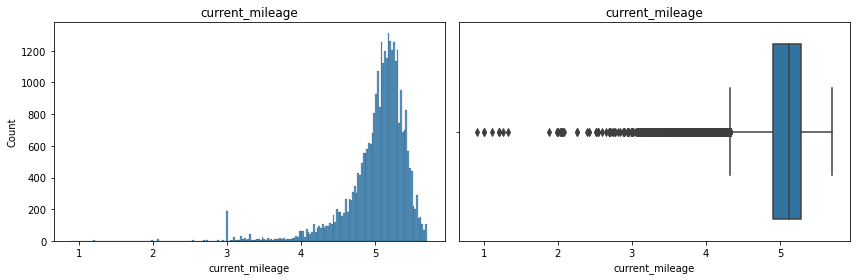

In [65]:
# Посмотрим распределение по признаку "current_mileage"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
histplot = sns.histplot(data=df_03, x='current_mileage', ax=axes[0])
histplot.set_title('current_mileage')
boxplot = sns.boxplot(data=df_03, x='current_mileage', ax=axes[1])
boxplot.set_title('current_mileage')

plt.tight_layout()
plt.show()

In [62]:
# Посмотрим на столбец с годом выпуска
df_03.sort_values(by='vehicle_year')

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,str_mileage
23708,23708,ROLLS-ROYCE,Phantom,Cabriolet,5.110590,1939,Automatic,4/5,Left wheel,Silver,White,NaN,1,For Rent,50,129000
32460,32460,ROLLS-ROYCE,Phantom,Limousine,5.227887,1939,Manual,4/5,Left wheel,White,Golden,NaN,1,For Rent,64,169000
17645,17645,MERCEDES-BENZ,S 500,Limousine,5.100371,1939,Automatic,4/5,Left wheel,White,Brown,0,1,For Rent,50,126000
29082,29082,GAZ,21,Limousine,5.100371,1939,Automatic,4/5,Left wheel,Silver,White,NaN,1,For Rent,50,126000
30042,30042,CADILLAC,Escalade,Sedan,4.322219,1940,Manual,4/5,Left wheel,Black,Black,NaN,0,For Sale,65000,21000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23093,23093,TOYOTA,Corolla,Sedan,2.264818,2020,Automatic,4/5,Left wheel,Silver,Orange,NaN,1,For Sale,6500,184
1831,1831,HYUNDAI,Santa FE,Jeep,4.095448,2020,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,28041,12458
31794,31794,TOYOTA,Camry,Sedan,3.549126,2020,Automatic,4/5,Left wheel,Black,Black,NaN,1,For Sale,150,3541
14373,14373,OPEL,Admiral,Jeep,5.000000,2020,Automatic,4/5,Left wheel,Green,Golden,NaN,1,For Sale,580,100000


In [66]:
# Уберем строки с машинами старше 1980 года
df_04 = df_03.drop(df_03[df_03['vehicle_year'] < 1980].index)
df_04.shape

(32712, 16)

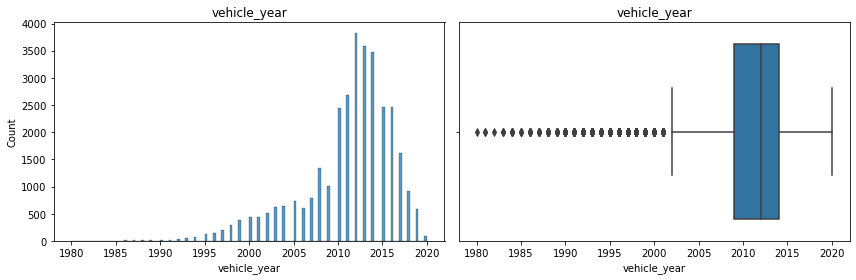

In [67]:
# Посмотрим распределение по признаку "vehicle_year"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
histplot = sns.histplot(data=df_04, x='vehicle_year', ax=axes[0])
histplot.set_title('vehicle_year')
boxplot = sns.boxplot(data=df_04, x='vehicle_year', ax=axes[1])
boxplot.set_title('vehicle_year')

plt.tight_layout()
plt.show()

In [68]:
# Посмотрим на столбец со стоимостью
df_04.sort_values(by='final_price')

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,str_mileage
7123,7123,CHEVROLET,Lacetti,Hatchback,5.301030,2006,Manual,4/5,Left wheel,Black,Grey,NaN,0,For Sale,0,200000
2856,2856,MERCEDES-BENZ,Viano,Minivan,5.269513,2009,Manual,4/5,Left wheel,Silver,Grey,NaN,1,For Rent,0,186000
16117,16117,MERCEDES-BENZ,Viano,Minivan,5.514548,2008,Tiptronic,4/5,Left wheel,Grey,Black,NaN,1,For Sale,1,327000
31675,31675,VOLKSWAGEN,Jetta,Sedan,4.612784,2016,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,1,41000
22243,22243,MERCEDES-BENZ,Sprinter,Microbus,5.176091,2005,Manual,4/5,Left wheel,White,Grey,NaN,0,For Rent,1,150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32937,32937,LAMBORGHINI,Gallardo,Coupe,4.414973,2013,Tiptronic,2/3,Left wheel,Yellow,Black,NaN,1,For Sale,135000,26000
19820,19820,PORSCHE,Panamera Turbo S E-Hyb,Sedan,4.204120,2017,Tiptronic,4/5,Left wheel,Carnelian red,White,NaN,1,For Sale,135000,16000
24980,24980,SUBARU,Legacy,Sedan,4.986772,2003,Manual,4/5,Right-hand drive,Silver,Black,NaN,1,For Sale,1111111,97000
12136,12136,BMW,328,Sedan,5.390935,2008,Automatic,4/5,Left wheel,Sky blue,Yellow,NaN,1,For Sale,1111111,246000


In [74]:
# Удалим строки где цена меньше 50 или выше 200000 и аренду
df_05 = df_04[
    (df_04['final_price'] > 50) 
    & (df_04['final_price'] <= 200_000) 
    & ~(df_04['deal_type'] == 'For Rent')
]
df_05.shape

(31707, 16)

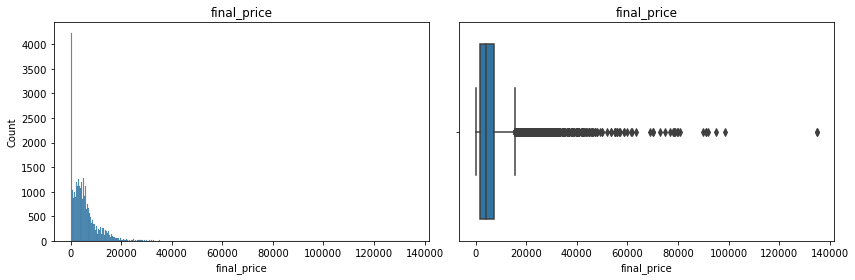

In [75]:
# Посмотрим распределение по признаку "final_price"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
histplot = sns.histplot(data=df_05, x='final_price', ax=axes[0])
histplot.set_title('final_price')
boxplot = sns.boxplot(data=df_05, x='final_price', ax=axes[1])
boxplot.set_title('final_price')

plt.tight_layout()
plt.show()

In [ ]:
# Осталось 5 столбцов с пропусками, заполним их значениями ('car_vin' оставим как есть)
df_03 = df_02.fillna({
    'vehicle_model': 'moda',
    'doors_cnt': 'median',
    'vehicle_color': 'median',
    'vehicle_interior_color': 'moda' 
})
df_03.info()

In [ ]:
# Сохраняем очищенный тренировочный датасет
train_data = df_03

In [ ]:
submission['final_price'] = train['final_price'].mean()
submission.head()

In [ ]:
# Проверим недостающие значения, если таковые имеется
submission.isnull().sum()

In [ ]:
submission.to_csv('corrected_submit.csv', index = False)